# Downloading Data


In [ ]:
# Download the dataset as a zip file
! wget https://cloudstor.aarnet.edu.au/plus/s/sXfWoQZ2CFbPzo0/download?path=%2F&files=annotatedLibrary.zip

In [ ]:
# unzip the file then remove it

! unzip /content/download?path=%2F
! rm /content/download?path=%2F

In [ ]:
# move the anotatedLibrary zip to the working folder and remove any extra files (data description....)
! mv /content/annotatedLibrary/annotatedLibrary.zip .
! rm -r /content/annotatedLibrary/

In [ ]:
# unzip the library and remove the zip file
! unzip /content/annotatedLibrary.zip
! rm /content/annotatedLibrary.zip

In [ ]:
# mount to drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# move dat ato drive for quick access
! mv /content/annotatedLibrary /content/drive/MyDrive/Projects/Data

Note: I edited the data files directly:
- renamed each xlsx file to ```meta.xlsx```
- transformed the annotations into quantitative values
    - present  -> 1.0
    - likely   -> 0.75
    - possibly -> 0.5
    - absent   -> 0.0
- fixed names in the ```wavFileName``` in each xlsx file

# Preparing Data

In this part we prepare data for training, this is done in three parts:
1. **data augmentation**: some folders have only 150 samples where others have more than 2000. It may prove useful to augment data to avoid any bias that may raise from different islands.
2. **feature extraction**: here we apply convert the wav files into spectrograms using librosa
    - sample rate: 250
    - window size: 512
    - stride     : 256
3. **data preparation**: convert the numpy array we got so far into dataloaders to feed to the training function.

In [93]:
### Load necessary libraries ###
import glob
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [4]:
# define the 'loadnpz' function to load '.npz' files       (saved extracted features)
import numpy as np
np.load.__defaults__=(None, False, True, 'ASCII')
np_load_old = np.load
loadnpz = lambda *a,**k: np_load_old(*a,allow_pickle=True)

In [5]:
# Used to avoid writing the while path to a file and to check if a file or a directory exist
class Path:
    def __init__(self, parent):
        self.working_folder = parent

    def get(self, sub):
        sub_f = os.path.join(self.working_folder, sub)
        if os.path.exists(sub_f):
            return sub_f
        raise Exception(f"No such folder or file with the name {sub} in {self.working_folder}")

    # get list of files of extension 'suff' in the directory 'folder'
    def endswith(self, folder, suff):
        subfolder = self.get(folder)
        subdirs = os.listdir(subfolder)
        files = []      
        for sub in subdirs:
            sub_f = os.path.join(subfolder, sub)
            if sub_f.endswith(suff) and os.path.isfile(sub_f):
                files.append(sub_f)
        return files

In [6]:
# data folder
work = Path('/content/drive/MyDrive/Projects/Data/annotatedLibrary')

# sub folders
folders = [
    'BallenyIslands2015',
    'ElephantIsland2013Aural',
    'ElephantIsland2014',
    'Greenwich64S2015',
    'MaudRise2014',
    'RossSea2014',
    'casey2014',
    'casey2017',
    'kerguelen2005',
    'kerguelen2014',
    'kerguelen2015'
]

# folder to save to
save_dir = 'processed/third'

## Data Augmentation

In [5]:
#- load a wav file
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp, sr=250)
        raw_sounds.append(X)
    return raw_sounds

# plot the wav file as plot line
def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(15,6))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()

# plot the spectrogram of the wav file
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(15,6))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(len(sound_names),1,i)
        specgram(np.array(f), Fs=250)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

#- plot the log power spectrogram of the wav file
def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(15,6))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

In [8]:
# add noise to a given sampple
def augment_noise(wav):
    wav = wav + 0.009 * np.random.normal(0,1,len(wav))
    return wav

# stretch time of a sample
def augment_time(wav, factor=.4):
    wav = librosa.effects.time_stretch(wav, factor)
    return wav

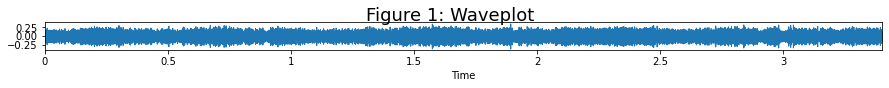

In [9]:
wav = load_sound_files(['/content/drive/MyDrive/Projects/Data/annotatedLibrary/ElephantIsland2013Aural/wav/20130112_130000_AWI251-01_AU0231_250Hz.wav'])[0]
plot_waves([""], [wav])

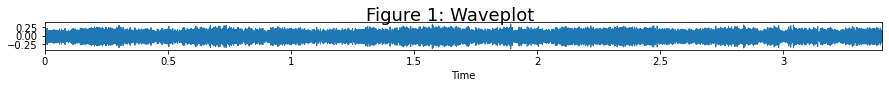

In [10]:
wav1 = augment_noise(wav)
plot_waves([""], [wav1])

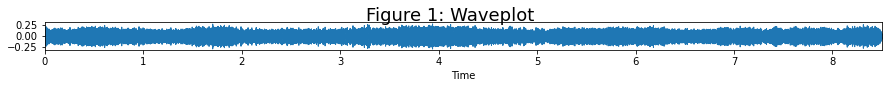

In [11]:
wav2 = augment_time(wav)
plot_waves([""], [wav2])

## Feature Extraction

In [ ]:
# This is the 90% work of the feature extraction
def parse_audio_files(dir,file_ext='*.wav'):
    print(f'Parsing: {dir}')
    # getting the meta file and wav folder
    meta = os.path.join(dir, 'meta.xlsx')
    wavf = os.path.join(dir, 'wav/')

    df = pd.read_excel(meta, engine='openpyxl')
    df = df[:100]                                   # using only 100 samples from each folder for quick
    files = list(df['wavFileName'])[:100]           # training and avoiding crushing the ram :(
    df = df[['Bm Ant-A', 'Bm Ant-B', 'Bm Ant-Z', 'BlueFM', 'Bp Downsweep', 'Bp 20Hz', 'Bp Higher_calls', 'Unidentified']]

    # Filling NaN cells and cast all columns to Float
    df = df.fillna(0)
    df['Bm Ant-A'] = df['Bm Ant-A'].astype(float) 
    df['Bm Ant-B'] = df['Bm Ant-B'].astype(float) 
    df['Bm Ant-Z'] = df['Bm Ant-Z'].astype(float) 
    df['BlueFM'] = df['BlueFM'].astype(float) 
    df['Bp Downsweep'] = df['Bp Downsweep'].astype(float) 
    df['Bp 20Hz'] = df['Bp 20Hz'].astype(float) 
    df['Bp Higher_calls'] = df['Bp Higher_calls'].astype(float) 
    df['Unidentified'] = df['Unidentified'].astype(float)

    train_data = []
    for f in tqdm(files):
        # correct the path to the file by adding the 'wav' extension if not existing
        if (f.endswith('.wav') or f.endswith('.WAV')):
            f = os.path.join(wavf, f)
        else:
            f = os.path.join(wavf, f+'.wav')
        # if the file exists, use librosa stft func to get magnitudes then turn them into a spectrogam
        if os.path.isfile(f):
            y, sr = librosa.load(f, sr=250)
            D = np.abs(librosa.stft(y, n_fft=512)) 
            data = librosa.feature.melspectrogram(S=D, n_fft=512, hop_length=256)
            train_data.append(data)
        else:
            raise Exception("Couldn't find: ", f)
    # assign spectrograms as a new column 'Data'
    df = df.assign(Data=train_data)
    #- just housekeeping to shift move the Data column first
    new_order = [8,0,1,2,3,4,5,6,7]
    df = df[df.columns[new_order]]
    # gether all albels into one 8 elements array
    df['Label'] = df[['Bm Ant-A', 'Bm Ant-B', 'Bm Ant-Z', 'BlueFM', 'Bp Downsweep', 'Bp 20Hz', 'Bp Higher_calls', 'Unidentified']].values.tolist()
    # return the Data and Label arrays
    return df['Data'].to_numpy(), df['Label'].to_numpy()

In [ ]:
# looping through all subfolders, extracting features from each
for sub_dir in folders:
    features, labels = parse_audio_files(work.get(sub_dir))
    # save the folder data as 'folder.npz' in 'save_dir'
    np.savez(work.get(save_dir)+'/'+sub_dir, features=features, labels=labels)

## Data preparation for the model

In [7]:
# Load the saved folders and stack them in two array : features & labels
features = []
labels = []
for sub in folders:
    print(sub)
    x = loadnpz(work.get(save_dir)+'/'+sub+'.npz')
    t = x['features']
    for i in range(len(t)):
        pl = 7033 - t[i].shape[1]
        # pad short arrays with zeros
        tl = np.pad(t[i], ((0,0), (0,pl)), constant_values=(0))
        features.append(tl.reshape((1,*tl.shape)))
        labels.append(np.array(x['labels'][i]))

BallenyIslands2015
ElephantIsland2013Aural
ElephantIsland2014
Greenwich64S2015
MaudRise2014
RossSea2014
casey2014
casey2017
kerguelen2005
kerguelen2014
kerguelen2015


In [8]:
# dimensions fixing
features = np.stack(features)
labels = np.stack(labels)

(features.shape, labels.shape)

((1100, 1, 128, 7033), (1100, 8))

In [9]:
# define a Dataset subclass for our data
class WhaleData(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels   = labels

    def __len__(self):
        assert len(self.features) == len(self.labels), "Fetaures length doesn't match labels length"
        return len(self.features)

    def __getitem__(self, idx):
        spec_tensor = torch.tensor(self.features[idx])
        spec_label = torch.tensor(self.labels[idx])
        return spec_tensor, spec_label

In [10]:
dataset = WhaleData(features, labels)

# train/test split : 8:2
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# creating the train and test dataloaders
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=1)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=1)

# Model Training

In [110]:
# define classes
classes = ('Bm Ant-A', 'Bm Ant-B', 'Bm Ant-Z', 'Blue FM', 'Bp Downsweep', 'Bp 20Hz', 'Bp Higher_call', 'Unidentified')
num_epochs = 100

# use the predefined ResNet18 defined in pytorch
model = models.resnet18(pretrained=False)
# fix the input dimensions to fit our data
model.conv1 = nn.Conv2d(
    1,
    model.conv1.out_channels,
    kernel_size=model.conv1.kernel_size[0],
    stride=model.conv1.stride[0],
    padding=model.conv1.padding[0]
)
# fix the output layer to fit our 8 classes
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.25), 
    nn.Linear(num_ftrs, len(classes)), 
    nn.Sigmoid()
)
model = model.float()

In [12]:
# defining the optimizer and criterion
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//3, gamma=.1)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# switching to GPU if available
device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
model.to(device); 

In [44]:
# used to threshhold the values into closer annotation
def threshold(arr):
    arr[arr > .85] = 1
    arr[np.where(np.logical_and(arr > .65, arr <= .85))] = .75
    arr[np.where(np.logical_and(arr > .35, arr <= .65))] = .5
    arr[arr < 0.35] = 0

    return arr

# calculate the accuracy
def accuracy(real, pred):
    pred = pred.detach().cpu()
    real = real.detach().cpu()

    pred = threshold(pred)
    
    return (pred == real).sum() / (len(real) * len(real[0])) * 100

In [15]:
# train the model for the given epoch
def train(model, epoch):
    model.train()

    accu_hist = []
    running_loss = 0
    loss_hist = []

    for idx, (data, label) in enumerate(train_loader):
        inputs = data.to(device) 
        label = label.to(device)

        optimizer.zero_grad()

        # feedforward and backpropagation steps
        outputs = model(inputs.float())
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        # collecting measures
        running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = accuracy(real=labels, pred=outputs) 
        accu_hist.append(epoch_acc)  
        loss_hist.append(epoch_loss)  

        if idx % 100 == 0:
            print(f'Train Epoch {epoch} : Iteration {idx}/{len(train_loader)} : Loss {running_loss}')

    return accu_hist, loss_hist

In [ ]:
accu_hist = []
loss_hist = []
# train for 2 epochs as an illustrtion
for e in range(2):#num_epochs):
    accu_hist, loss_hist = train(model, e)
    scheduler.step()

In [17]:
print(f'Training average accuracy: {np.sum(np.array(accu_hist)) / len(accu_hist)}%')

Training average accuracy: 74.37079239757594%


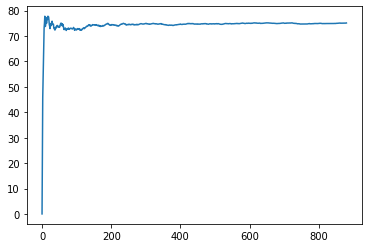

In [18]:
# we can see that the model reach a 70% accuracy
plt.plot(accu_hist)

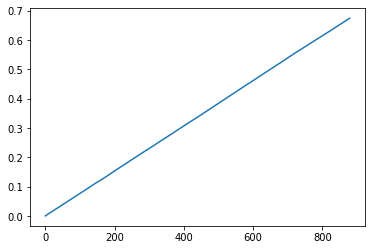

In [19]:
# the loss is nearly constant through epochs
plt.plot(loss_hist)

In [ ]:
# Testing the model on testloader
model.to(device)
model.eval()
avg_acc = 0

all_labels  = []
all_outputs = []

for idx, (data, label) in enumerate(test_loader):
    inputs = data.to(device) 
    labels = label.to(device)

    outputs = model(inputs.float())

    all_labels.append(labels.detach().cpu().numpy())
    outputs = threshold(outputs.detach().cpu())
    all_outputs.append(outputs.numpy())

    avg_acc += accuracy(real=labels, pred=outputs) / len(test_loader)
  
print(f'Testing average Accuracy = {avg_acc}%')  

In [47]:
# calclate the confusion matrix
# NOTICE: since we care only about the presence of class 
#         we lit only correctly/wrongly classified samples for each class
all_labels = np.stack(all_labels, axis=0)
all_outputs = np.stack(all_outputs, axis=0)

all_labels = all_labels.reshape((all_labels.shape[0], all_labels.shape[2]))
all_outputs = all_outputs.reshape((all_outputs.shape[0], all_outputs.shape[2]))

confusion_matrix = np.zeros((len(classes), 2))

for i in range(all_labels.shape[1]):
    for j in range(all_labels.shape[0]):
        if all_labels[j,i] == all_outputs[j,i]:
            confusion_matrix[i, 0] += 1
        else:
            confusion_matrix[i, 1] += 1
            
confusion_matrix /= all_labels.shape[0]

In [91]:
# fancing prenting for screenshots ;)
print('\t\t   Correct \t Wrong')
for i in range(confusion_matrix.shape[0]):
    print(f'{classes[i]} \t : {confusion_matrix[i,0]*100:5.2f} % \t {confusion_matrix[i,1]*100:5.2f} %')

		   Correct 	 Wrong
Bm Ant-A 	 : 18.64 % 	 81.36 %
Bm Ant-B 	 : 61.36 % 	 38.64 %
Bm Ant-Z 	 : 76.36 % 	 23.64 %
Blue FM 	 : 73.64 % 	 26.36 %
Bp Downsweep 	 : 80.45 % 	 19.55 %
Bp 20Hz 	 : 91.36 % 	  8.64 %
Bp Higher_call 	 : 97.27 % 	  2.73 %
Unidentified 	 : 55.00 % 	 45.00 %


# DenseNet Model

The same as resnet use the predefinced model with some tweaks in the input and output dimensions.

In [116]:
classes = ('Bm Ant-A', 'Bm Ant-B', 'Bm Ant-Z', 'Blue FM', 'Bp Downsweep', 'Bp 20Hz', 'Bp Higher_call', 'Unidentified')
num_epochs = 100

model = models.densenet121(pretrained=False)

model.features.conv0 = nn.Conv2d(
    1,
    model.features.conv0.out_channels,
    kernel_size=model.features.conv0.kernel_size[0],
    stride=model.features.conv0.stride[0],
    padding=model.features.conv0.padding[0]
)

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.25), 
    nn.Linear(num_ftrs, len(classes)), 
    nn.Sigmoid()
)

model = model.float()
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inp

In [117]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//3, gamma=.1)
criterion = nn.BCEWithLogitsLoss()

In [118]:
device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
model.to(device);

Device:  0


# Inception Model

The only difference in this model is that it took too much time to load to memory so I just aborted it. It uses the predefined model too.

In [125]:
# Didn't try it since it takes a lot of time just to create the model!

model = models.Inception3(
    num_classes=len(classes),
    aux_logits=False
)

model = model.float()
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


KeyboardInterrupt: ignored